In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pylab as plt
import matplotlib.cm as cm
from astropy.time import Time
import astropy.units as u
from pulsar.predictor import Polyco
from scipy.stats import binned_statistic
import glob

In [2]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine / abs(p1fine)) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def wfilter(p2, p1, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)

    # Hardcoded, which is unfortunate
    #SN = (abs(p1fine[32])- abs(p1fine[:20]).mean(axis=0)) / abs(p1fine)[:20].std(axis=0)
    SN = abs(p1fine[0])
    SN[SN < 0.01] = 0.01
    H = p1fine / abs(p1fine)
    G = (1 / H) * ( abs(H)**2.0 / (abs(H)**2.0 + (1/SN[np.newaxis,:])) )
    Y = p2fine

    x = rechannelize(G * Y, cchan)
    return x

def power(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    power = (abs(dR)**2 + abs(dL)**2)
    return power

def powerchan(dchan):
    R = np.array([8,0,10,2,12,4,14,6])
    L = np.array([9,1,11,2,13,5,15,7])
    dR = dchan[...,R]
    dL = dchan[...,L]
    power = abs(dR)**2.0 + abs(dL)**2.0
    return power

def normpower(pulse):
    p1temp = rechannelize(pulse, 256)
    power1 = abs(p1temp)**2.0
    power1 = power1[16] - power1[2:12].mean(axis=0)
    power1 = power1[32:-32]
    power1 = (power1 - power1.mean(axis=0)) / power1.std(axis=0)
    return power1

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse


In [3]:
"""
Load all b1957 Pulses
"""

b1957GPs = np.loadtxt('/media/drive2/b1957-GPs/gp_RCP.txt', dtype='string')
                      
bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

SNcut = 12
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

#bSN = bSN[abs(bphase-0.8) < 0.1 ]
#bT = bT[abs(bphase-0.8) < 0.1 ]
#bphase = bphase[abs(bphase-0.8) < 0.1 ]


"""
Take only first two days for simpicity (i.e. ignore weirdness at eclipse)
"""

#bphase = bphase[bT < Time('2014-06-13T07:30:00')]
#bSN = bSN[bT < Time('2014-06-13T07:30:00')]
#bT = bT[bT < Time('2014-06-13T07:30:00')]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

#print bT

#Tphase = bT

bdT = bT.unix - np.roll(bT.unix, 1)
bsort = np.argsort(bdT)
#bdT[bsort]

In [4]:
"""
Re-Calculate Phases with Alex's corrected polyco
"""

psr_polyco = Polyco('/home/ramain/packages/scint_analysis/b1957_GPs/polycob1957+20_ao.dat')
#psr_polyco = Polyco('/home/ramain/trials/b1957/polycob1957+20_ao.dat')
#psr_polyco = Polyco('/home/ramain/Ephemerides/polycob1957+20_ao.dat')

phase_pol = psr_polyco.phasepol(bT[0])

pt = []
for i in range(len(bT)):
    time = bT[i]
    phase_pol = psr_polyco.phasepol(time)
    bphase[i] = np.remainder(phase_pol(time.mjd), 1)

bphase = np.remainder(bphase+0.82, 1)
plt.plot(bphase[:3600], (bT.unix - bT[0].unix)[:3600], 'bx')
plt.xlim(0.77, 0.83)

/usr/local/lib/python2.7/dist-packages/astropy/table/column.py:331: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return super(BaseColumn, self).__getitem__(item)


(0.77, 0.83)

In [16]:
"""
Find better polyco, because it's about friggin' time

Pulsar timing?
"""
"""
psr_polyco = Polyco('/home/ramain/packages/scint_analysis/b1957_GPs/polycob1957+20_ao.dat')
psr_polyco = Polyco('/home/ramain/trials/b1957/polycob1957+20_ao.dat')
psr_polyco = Polyco('/home/ramain/Ephemerides/polycob1957+20_ao.dat')

for i in range(len(bT)):
    time = bT[i]
    phase_pol = psr_polyco.phasepol(time)
    bphase[i] = np.remainder(phase_pol(time.mjd), 1)

bphase = np.remainder(bphase+0.82, 1)

MPphase = bphase[abs(bphase-0.8) < 0.2]
MPT = bT[abs(bphase-0.8) < 0.2]
MPphase = MPphase[abs(MPT.unix - Time('2014-06-13T06:30:00').unix) < 18000 ]
MPT = MPT[abs(MPT.unix - Time('2014-06-13T06:30:00').unix) < 18000 ]

print(MPphase.shape, MPT.shape)

Tbins = np.linspace(0,8000,21)
phase_binned = binned_statistic(MPT.unix - MPT[0].unix, MPphase, statistic='mean', bins = Tbins)[0]

plt.plot(phase_binned, Tbins[:-1], 'k')
#plt.xlim(0.75, 0.85)
plt.xlabel('phase')
plt.ylabel('time [s]')
plt.savefig('EphTrial4.pdf')
"""

"\npsr_polyco = Polyco('/home/ramain/packages/scint_analysis/b1957_GPs/polycob1957+20_ao.dat')\npsr_polyco = Polyco('/home/ramain/trials/b1957/polycob1957+20_ao.dat')\npsr_polyco = Polyco('/home/ramain/Ephemerides/polycob1957+20_ao.dat')\n\nfor i in range(len(bT)):\n    time = bT[i]\n    phase_pol = psr_polyco.phasepol(time)\n    bphase[i] = np.remainder(phase_pol(time.mjd), 1)\n\nbphase = np.remainder(bphase+0.82, 1)\n\nMPphase = bphase[abs(bphase-0.8) < 0.2]\nMPT = bT[abs(bphase-0.8) < 0.2]\nMPphase = MPphase[abs(MPT.unix - Time('2014-06-13T06:30:00').unix) < 18000 ]\nMPT = MPT[abs(MPT.unix - Time('2014-06-13T06:30:00').unix) < 18000 ]\n\nprint(MPphase.shape, MPT.shape)\n\nTbins = np.linspace(0,8000,21)\nphase_binned = binned_statistic(MPT.unix - MPT[0].unix, MPphase, statistic='mean', bins = Tbins)[0]\n\nplt.plot(phase_binned, Tbins[:-1], 'k')\n#plt.xlim(0.75, 0.85)\nplt.xlabel('phase')\nplt.ylabel('time [s]')\nplt.savefig('EphTrial4.pdf')\n"

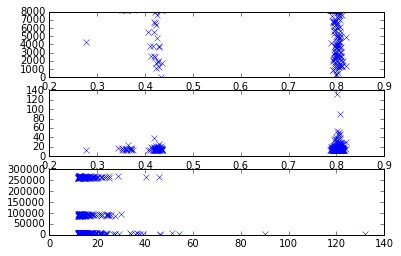

In [5]:
%matplotlib inline
plt.subplot(311)
plt.plot(bphase, bT.unix - bT[0].unix, 'bx')
plt.ylim(0,8000)

plt.subplot(312)
plt.plot(bphase, bSN, 'bx')

plt.subplot(313)
plt.plot(bSN, bT.unix - bT[0].unix, 'bx')

323.247226517 0.0222574592082


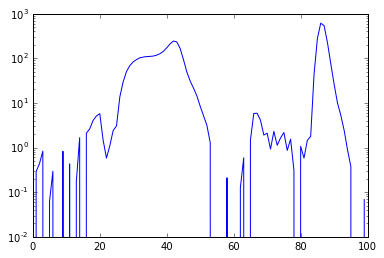

In [6]:
"""
Load Folded Profile
"""

foldSN = np.load('/media/drive2/b1957-GPs/folded/b1957_SNprofile.npy')

# Mean and sigma in log space as a functions of phase - i.e. log-normal PDF for each phase bin
foldsig = np.load('/media/drive2/b1957-GPs/folded/sigma.npy')
foldmean = np.load('/media/drive2/b1957-GPs/folded/mean.npy')

foldSN_binned = foldSN.reshape(100,10).mean(-1) * np.sqrt(10)

bg = np.concatenate((foldmean[52:65],foldmean[0:15]))
norm_mean = (10**(bg)).mean()
norm_sig = (10**(bg)).std()
print norm_mean, norm_sig
profile = 10**(foldmean)
profile = (profile - norm_mean) / norm_sig

sig_one = 10**(foldmean + 1*foldsig)
sig_one = (sig_one - norm_mean) / norm_sig
sig_three = 10**(foldmean + 3*foldsig)
sig_three = (sig_three - norm_mean) / norm_sig
sig_five = 10**(foldmean + 5*foldsig)
sig_five = (sig_five - norm_mean) / norm_sig

#sig_contour = 10**(np.log10(SNforcont) + 10*foldsig)

#SNforcont = 1.*foldSN_binned
        
#sig_contour = 10**(np.log10(SNforcont) + 10*foldsig)
coarse_bins = np.linspace(0,1,100)

#plt.subplot(211)
plt.plot(profile)
#plt.plot(sigcont)
#plt.plot(10**foldmean)
#plt.subplot(212)
#plt.plot(foldSN_binned)
#plt.plot(sig_contour)

plt.yscale('log')

#npulses = 16125419 # (2.4hours * 3 / pulse period)
npulses = 335320*15*3


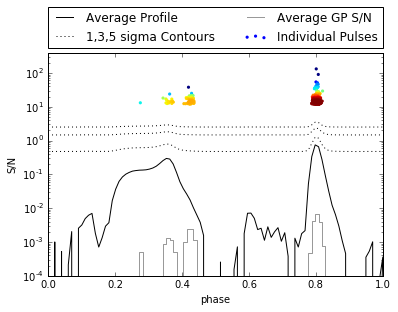

In [7]:
"""
FIGURE 1 A
"""
from scipy.stats import binned_statistic
from scipy.stats import gaussian_kde


#GPhist = binned_statistic(bphase, bSN, statistic='sum', bins = GPbins)[0]
#GPhist2 = binned_statistic(bphase, bSN, statistic='count', bins = GPbins)[0]
#plt.plot(GPbins[:-1], GPhist / np.sqrt(GPhist2), 'ko-', markersize=1, label='Summed GP S/N')

xy = np.vstack([bphase,bSN])
z = np.log10(gaussian_kde(xy)(xy))

idx = z.argsort()
x, y, z = bphase[idx], bSN[idx], z[idx]

plt.scatter(x, y, c=z, s=10, edgecolor='', label='Individual Pulses')
#plt.plot(bphase, bSN, 'ko', markersize=0.2, label='Individual Pulses')
#plt.plot(np.roll(coarse_bins,7), foldSN_binned, color='0', label='Average Profile')
#plt.plot(np.roll(coarse_bins,7), sig_contour, 'k--', color='0', label='??? Contour')

'''
average pulse SN is integrated / sqrt(Npulses)
sqrt(2) comes from only one pol being used?
Incoherent shift to align the pulses, with Nikhil's different Fref 
(checked that this indeed lines them up)
'''
plt.plot(np.roll(coarse_bins,7), profile/np.sqrt(335320*2), 'k', label='Average Profile')
plt.plot(coarse_bins, np.roll(sig_one,-7)/np.sqrt(335320*2), 'k:', color='0', label='1,3,5 sigma Contours')
plt.plot(coarse_bins, np.roll(sig_three,-7)/np.sqrt(335320*2), 'k:', color='0')
plt.plot(coarse_bins, np.roll(sig_five,-7)/np.sqrt(335320*2), 'k:', color='0')

# Add average integrated Pulse emission
GPhist = binned_statistic(bphase, np.sqrt(bSN), statistic='sum', bins = coarse_bins)[0]

histplot = np.sqrt(GPhist)
histplot[np.isnan(histplot)] = 1.e-5
histplot[histplot==0] = 1.e-5

plt.plot(coarse_bins[1:], histplot/np.sqrt(npulses), color='0.6', label='Average GP S/N', drawstyle='steps')

#plt.plot(np.roll(GPbins,70), np.sqrt(5)*foldSN, color='0', label='Average Profile')

plt.ylabel('S/N')
plt.xlabel('phase')
plt.xlim(0,1)
plt.ylim(1e-4, 400)
plt.yscale('log')
#plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('fig1a.pdf')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


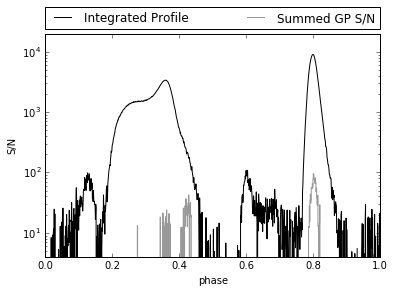

In [8]:
"""
FIGURE 1 B
"""
from scipy.stats import binned_statistic

#plt.plot(bphase, bSN, 'kx')

GPbins = np.linspace(0,1,1000)

GPhist = binned_statistic(bphase, bSN, statistic='sum', bins = GPbins)[0]
GPhist2 = binned_statistic(bphase, bSN, statistic='count', bins = GPbins)[0]

histplot = GPhist / np.sqrt(GPhist2)
histplot[np.isnan(histplot)] = 1

plt.plot(np.roll(GPbins,70), np.sqrt(5)*foldSN * np.sqrt(npulses), color='0', label='Integrated Profile')
plt.plot(GPbins[:-1], histplot, color='0.6', label='Summed GP S/N', drawstyle='steps')

plt.ylabel('S/N')
plt.xlabel('phase')
plt.xlim(0,1)
plt.ylim(4, 2e4)
plt.yscale('log')#, nonposy='clip')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.savefig('fig1b.pdf')

ERROR: NameError: name 'MPtypical' is not defined [IPython.core.interactiveshell]


NameError: name 'MPtypical' is not defined

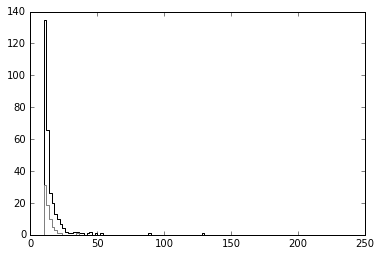

In [9]:
"""
Create PDF of Pulse Brightness

FIGURE 1C
"""

#SNbins = np.logspace(np.log10(6),np.log10(max(bSN)), 30)
SNbins = np.linspace(6,206, 101)

MPSN = bSN[abs(bphase-0.8) < 0.1 ]
IPSN = bSN[abs(bphase-0.38) < 0.1 ]

MPhist = np.histogram(MPSN, bins=SNbins)[0]
IPhist = np.histogram(IPSN, bins=SNbins)[0]
    
plt.plot(SNbins[:-1], MPhist+1e-5, drawstyle='steps', label='Main Pulse', color = '0.0')
plt.plot(SNbins[:-1], IPhist+1e-5, drawstyle='steps', label='Interpulse', color = '0.5')

plt.plot(np.sqrt(5)*MPtypical, npulses, 'kx')
plt.plot(np.sqrt(5)*IPtypical, npulses, '+', color = '0.5')

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1,2*npulses)
plt.xlim(IPtypical/2,150)
plt.legend()
plt.xlabel( 'S/N' )
plt.ylabel('N pulses')
plt.savefig('fig1c.pdf')

In [10]:
"""
Look at Polarization Profile of Brightest Pulses
"""

GP_Tlist = Time(['2014-06-13T06:01:21.91125', '2014-06-13T06:01:23.83364', 
                 '2014-06-13T06:06:35.94089'], precision=5)

pad = np.zeros((100,1))

for t_gp in GP_Tlist:

    GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
    GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

    GPR = np.concatenate((GPR,pad), axis=-1)
    GPL = np.concatenate((GPL,pad), axis=-1)

    GPR = rechannelize(GPR, 48)[750:900]
    GPL = rechannelize(GPL, 48)[750:900]

    I, Q, U, V = Stokes(GPR, GPL)

    L = Q + 1j*U

    plt.plot(I.sum(1) - I.sum(1)[:40].mean(0), 'k', label='I')
    plt.plot(abs(L).sum(1) - abs(L).sum(1)[:40].mean(0), 'r', label='|L|')
    plt.plot(V.sum(1) - V.sum(1)[:40].mean(0), 'b', label='V')
    plt.legend()
    
    plt.xlabel('Time [microseconds]')
    plt.ylabel('Intensity')
    
    plt.savefig('b1957_GP%s.pdf' % (t_gp.isot))
    plt.clf()

ts = -12.2088526955


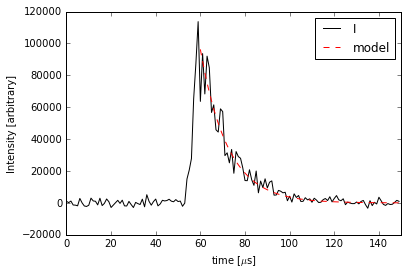

In [11]:
"""
Profile of Brightest Pulse

Calculation of scattering time from exponential fit
"""

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))

GPR = np.concatenate((GPR,pad), axis=-1)
GPL = np.concatenate((GPL,pad), axis=-1)

GPR = rechannelize(GPR, 48)[750:900]
GPL = rechannelize(GPL, 48)[750:900]

I, Q, U, V = Stokes(GPR, GPL)

Iscattering = I.sum(1) - I.sum(1)[:40].mean(0)
Is_fit = np.log(Iscattering[60:110])
t_fit = np.linspace(0, 50, 51)[:-1]
bfit = np.polyfit(t_fit, Is_fit, 1)

t_plot = np.linspace(0, 100, 101)[:-1]
model = bfit[0]*t_plot + bfit[1]

print("ts = %s" % (1 / bfit[0]))

plt.plot(Iscattering, 'k', label='I')
plt.plot(t_plot+60, np.exp(model), 'r--', label = 'model')
plt.xlim(0, 150)
plt.xlabel(r'time [$\mu$s]')
plt.ylabel('Intensity [arbitrary]')
plt.legend()

plt.savefig('ScatteringTail.pdf')

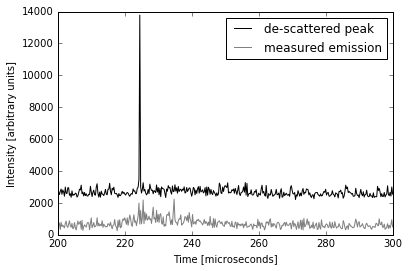

In [12]:
'''
FIGURE 4 - The moneyplot!

De-Scatter the 2s bright pair
'''

t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
t_p = Time('2014-06-13T06:01:23.83364', precision=5)
pad = np.zeros((100,1))


p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_ref.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p.isot))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)

p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2temp, 1034-np.argmax(abs(p2temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
p2prof = rechannelize(p2temp, 4*3)

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

plt.plot(t_axis, (abs(corr)**2.0).sum(-1) + 2000,'k' , label='de-scattered peak')
plt.plot(t_axis, (abs(p2prof)**2.0).sum(-1), 'grey', label='measured emission')

plt.xlim(200, 300)
plt.ylabel('Intensity [arbitrary units]')
plt.xlabel('Time [microseconds]')
plt.legend()
plt.savefig('descatter-bestpair.pdf')

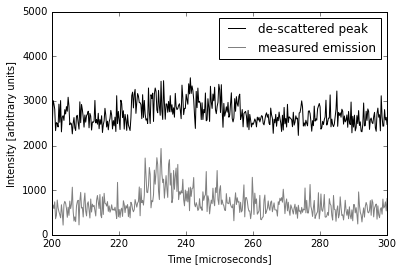

In [13]:
'''
FIGURE 4b - The less money, but rather comparative plot

De-Scatter the 2s bright pair
'''

t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
t_p = Time('2014-06-13T06:06:35.94089', precision=5)
pad = np.zeros((100,1))


p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_ref.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p.isot))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)

p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2temp, 1032-np.argmax(abs(p2temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
p2prof = rechannelize(p2temp, 4*3)

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

plt.plot(t_axis, (abs(corr)**2.0).sum(-1) + 2000,'k' , label='de-scattered peak')
plt.plot(t_axis, (abs(p2prof)**2.0).sum(-1), 'grey', label='measured emission')

plt.xlim(200, 300)
plt.ylim(0,5000)
plt.ylabel('Intensity [arbitrary units]')
plt.xlabel('Time [microseconds]')
plt.legend()
plt.savefig('descatter-arbpair.pdf')

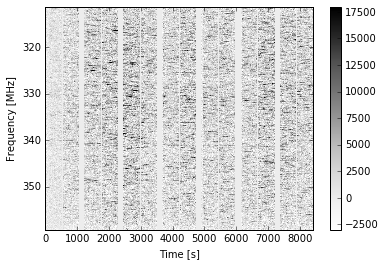

In [15]:
"""
Load Dynamic spectra to do incoherent scintillation analysis

CURRENTLY INCLUDED IN PAPER
"""

dyn1 = np.load('/home/ramain/trials/b1957/b1957-20140613.npy')
dyn2 = np.load('/home/ramain/trials/b1957/b1957-20140614.npy')
dyn3 = np.load('/home/ramain/trials/b1957/b1957-20140615.npy')
dyn4 = np.load('/home/ramain/trials/b1957/b1957-20140616.npy')

dynb = dyn1.reshape(-1,1000,8).sum(-1)
dynb = dynb[:,:750]

#dynb = 1.*dyn1
#dynb = dynb[:,:6000]

%matplotlib inline
plt.imshow(dynb.T, aspect='auto', interpolation='nearest', cmap=cm.Greys,
           vmin=-3000, vmax=18000, extent=[0,dynb.shape[0]*3, 359.25, 311.25])
plt.ylabel('Frequency [MHz]')
plt.xlabel('Time [s]')
plt.colorbar()

(40, 750)


(-1, 180)

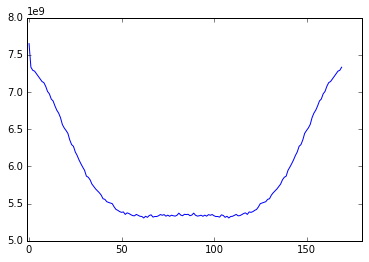

In [67]:
"""
Compute correlation timescale from dynspec

First compute 2D corr to get noise properties
"""
%matplotlib inline
chunk = 170
bgchunk = 40

dyncorr = np.zeros((chunk,dynb.shape[1]))
dynbg = np.zeros((bgchunk,dynb.shape[1]))
tdyncorr = []

# First 40 bins are empty, use this to calibrate noise
dynb_sub = dynb[:bgchunk]

for i in range(bgchunk):
    dyn1 = 1.*dynb_sub
    dyn2 = np.roll(dynb_sub,i,axis=0)
    dynbg[i] = np.mean(dyn1*dyn2, axis=0)

dynb_sub = dynb[410:410+chunk]

print dynbg.shape

for i in range(chunk):
    dyn1 = 1.*dynb_sub
    dyn2 = np.roll(dynb_sub,i,axis=0)
    if i == 0:
        dyncorr[i] = np.mean((dyn1-np.sqrt(dynbg[0])) *( dyn2-np.sqrt(dynbg[0])), axis=0)
    else:
        dyncorr[i] = np.mean(dyn1*dyn2, axis=0)

    tdyncorr.append(i*3)

dyncorr = np.array(dyncorr)    

plt.plot(dyncorr.sum(1))
#plt.plot(dynbg.sum(1))
plt.xlim(-1,180)

342329.524625 6503512.85633


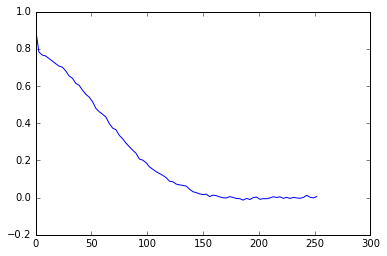

In [68]:
"""
Bins 60-110 look like noise, use them to calibrate

R  =       (p1-p1.mean) * (p2-p2.mean)
           ___________________________
     
     sqrt((sig1^2 - sig1n^2)(sig1^2 - sig1n^2))

"""

chunk = 170

dynclean = 1.*dyncorr
bg_m1 = dynclean[65:105].mean()#axis=0, keepdims=True)
bg_s = dynclean[65:105].std()#axis=0, keepdims=True)
bg_bg = dynbg[0].std()
print bg_bg, bg_s

dynclean = (dynclean-bg_m1) / np.sqrt(dynclean.std()**2.0 - bg_s**2.0)
dyncorr_cal = dynclean[:85].mean(1)
tdyncorr = np.array(tdyncorr)[:85]

plt.plot(tdyncorr, dyncorr_cal)



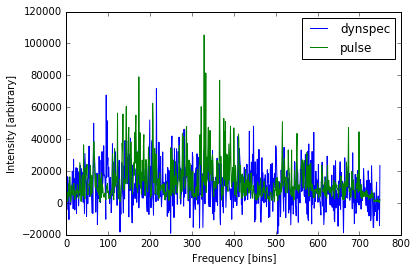

In [88]:
"""
Compute time difference between giant pulse and start of observation

Use this to find part in dynamic spectrum where giant pulse arrives
"""

t_gp = Time('2014-06-13T06:01:21.91125', precision=5)
#t_gp = Time('2014-06-13T07:00:02.13597', precision=5)

t0 = Time('2014-06-13T05:35:46')

dT = t_gp.unix - t0.unix
Tbin = int(dT // 3)
GPdyn = dynb[Tbin]

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

GP = abs(GPR[50])**2.0 + abs(GPL[50])**2.0
GPbg = (abs(GPR[40])**2.0 + abs(GPL[40])**2.0)

f1 = np.linspace(0,750,750)
f2 = np.linspace(0,750,768)

GP = np.interp(f1,f2,GP)
GPbg = np.interp(f1,f2,GPbg)

plt.plot(GPdyn*4, label='dynspec')
plt.plot(GP, label='pulse')
plt.legend()
plt.xlabel('Frequency [bins]')
plt.ylabel('Intensity [arbitrary]')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


(3204.5176446729447, 12209.798460019569, 3604.6633308742312, 1003.0372398441148)


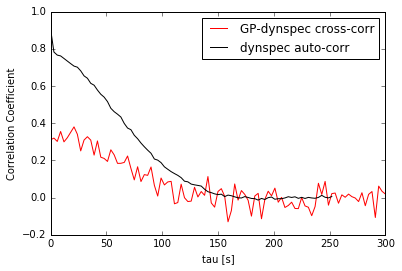

In [101]:
"""
Compute cross correlation between GP spectra and dynamic spectra

It should be maximal at zero lag if the pattern are the same
REQUIRES PREVIOUS STEPS ON DYNSPEC TO GET tdyncorr, dyncorr_cal

FIGURE 4 IN PAPER
"""

N = 400
ccarray = np.zeros(N)
tgpcorr = []

j=0
for i in range(-N//2, N//2):
    d1 = dynb[Tbin+i]
    d2 = GP
    d3 = GPbg
    d4 = dynb[10]
    ctemp = np.mean((GP - GP.mean())*(dynb[Tbin+i] - dynb[Tbin+i].mean()) / 
                np.sqrt(( (d1.std()**2.0 - d4.std()**2.0)*(d2.std()**2.0 - d3.std()**2.0))) )
    ccarray[j] = ctemp
    tgpcorr.append(i*3)
    j+=1

print (d1.std(), d2.std(), d3.std(), d4.std() )

ccarray_p = ccarray - np.median(ccarray[np.isfinite(ccarray)])
ccarray_p[np.isnan(ccarray)] = 0
cc_post = ccarray_p[len(ccarray_p)//2::-1][1:] + ccarray_p[len(ccarray_p)//2:]

plt.plot(tgpcorr[len(tgpcorr)//2:], cc_post, 'r', label='GP-dynspec cross-corr')
plt.plot(tdyncorr, dyncorr_cal, 'k', label='dynspec auto-corr')
plt.ylabel('Correlation Coefficient')
plt.xlabel('tau [s]')
plt.xlim(0,300)
plt.legend()
plt.savefig('DynCorr.pdf')

In [102]:
"""
Set up pulse lists for de-scattering
"""

b1957GPs = np.loadtxt('/media/drive2/b1957-GPs/gp_RCP.txt', dtype='string')
                      
bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

# Pulses used as Green's function measurements
SNcut = 40
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

bSN = bSN[abs(bphase-0.8) < 0.1 ]
bT = bT[abs(bphase-0.8) < 0.1 ]
bphase = bphase[abs(bphase-0.8) < 0.1 ]

print bT

Tphase = bT
Tphase = np.delete(Tphase,7)
Tphase = np.delete(Tphase,4)

print Tphase

bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

# Pulses for de-scattering
SNcut = 12
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

bSN = bSN[abs(bphase-0.8) < 0.1 ]
bT = bT[abs(bphase-0.8) < 0.1 ]
bphase = bphase[abs(bphase-0.8) < 0.1 ]

bdT = bT.unix - np.roll(bT.unix, 1)
bsort = np.argsort(bdT)

['2014-06-13T06:01:21.91125' '2014-06-13T06:19:34.04710'
 '2014-06-13T06:49:56.52016' '2014-06-13T07:00:02.13597'
 '2014-06-13T07:00:02.13598' '2014-06-13T07:45:04.81882'
 '2014-06-16T07:09:37.37527' '2014-06-16T07:09:37.37528']
[<Time object: scale='utc' format='isot' value=2014-06-13T06:01:21.91125>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:19:34.04710>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:49:56.52016>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:00:02.13597>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:45:04.81882>
 <Time object: scale='utc' format='isot' value=2014-06-16T07:09:37.37527>]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:77: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


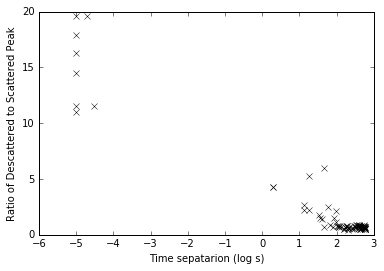

In [103]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 

FIGURE in Paper
"""

Tcal = Tphase[0]

buff = 0
wiener = 0
cchan = 16*3
fchan = 512*3
timespan = 600 # time to correlate each GP with

%matplotlib qt

for j in range(len(Tphase)):

    td = []
    Tcal = Tphase[j]
    
    pb_dT = abs(bT.unix - Tcal.unix)
    T2 = bT[pb_dT < timespan]
    npulses = len(T2)
    pratio = np.zeros(npulses)
    pratio2 = np.zeros(npulses)

    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (Tcal.isot))
    p1 = np.concatenate((p1,pad), axis=1)
    #p1 = np.roll(p1, j*256, axis=1)[:,:257]

    for i in range(buff,npulses+buff):
        try:
            p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))
            p2 = np.concatenate((p2,pad), axis=1)
        except: 
            print("file %s does not exist" % (T2[i]))

        p1prof = (abs(rechannelize(p1,cchan))**2.0).sum(-1)
        p2prof = (abs(rechannelize(p2,cchan))**2.0).sum(-1)

        p1temp = np.roll(rechannelize(p1,cchan), 514-np.argmax(p1prof), axis=0)
        p2temp = np.roll(rechannelize(p2,cchan), 514-np.argmax(p2prof), axis=0)

        bg = p2prof[100:len(p2prof)/4].mean(axis=0)

        p12corr = correlate(p2temp, p1temp, cchan, fchan)
        
        if wiener:
            p12pcorr = wfilter(p1temp, p2temp, cchan, fchan)
            corrnorm = bg / (abs(p12pcorr[100:300])**2.0).sum(-1).mean(axis=0)
        else:
            p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
            corrnorm = 1.

        pd = max( (abs(p12pcorr)**2.0).sum(1)*corrnorm - bg )
        ps = max(p2prof - bg)
        
        pd2 = max( (abs(p12pcorr)**2.0).sum(1)[520:528] - bg )
        ps2 = max( (abs(p2temp)**2.0).sum(1)[520:528] - bg )
        
        pratio[i-buff] = (pd / ps)
        pratio2[i-buff] = (pd2 / ps2)

        td.append(abs(Tcal.unix - Time(T2[i]).unix))
    
    if j==0:
        pr1 = 1*pratio
        pr2 = 1*pratio2
        td1 = 1.*np.array(td)
    else:
        pr1 = np.concatenate((pr1,pratio))
        pr2 = np.concatenate((pr2,pratio2))
        td1 = np.concatenate((td1,np.array(td)))


    plt.plot(np.log10(td), pratio, 'kx')
    #plt.plot(np.log10(td), pratio2, 'rx')
    
#plt.plot(np.log10(np.sort(td)), prun[np.argsort(td)] / 3, 'k--', label='mean')
#plt.xlim(0,4)
#plt.ylim(0,5)
#plt.plot(pratio, 'bx')
plt.xlabel('Time sepatarion (log s)')
plt.ylabel('Ratio of Descattered to Scattered Peak')
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in log10


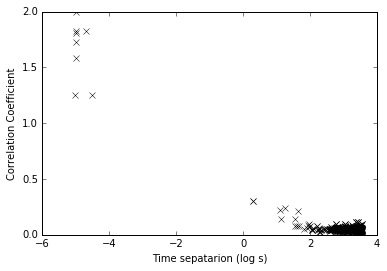

In [104]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 
USING VISIBILITY METHOD

FIGURE in Paper
"""

Tcal = Tphase[0]

buff = 0
wiener = 0
cchan = 16*3
fchan = 512*3
timespan = 3600 # time to correlate each GP with

%matplotlib qt

for j in range(len(Tphase)):

    td = []
    Tcal = Tphase[j]
    
    pb_dT = abs(bT.unix - Tcal.unix)
    T2 = bT[pb_dT < timespan]
    npulses = len(T2)
    pratio = np.zeros(npulses)
    pratio2 = np.zeros(npulses)

    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (Tcal.isot))
    p1 = np.concatenate((p1,pad), axis=1)

    for i in range(buff,npulses+buff):
        try:
            p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))
            p2 = np.concatenate((p2,pad), axis=1)
        except: 
            print("file %s does not exist" % (T2[i]))

        p1prof = (abs(rechannelize(p1,cchan))**2.0).sum(-1)
        p2prof = (abs(rechannelize(p2,cchan))**2.0).sum(-1)

        p1temp = np.roll(rechannelize(p1,cchan), 514-np.argmax(p1prof), axis=0)
        p2temp = np.roll(rechannelize(p2,cchan), 514-np.argmax(p2prof), axis=0)


        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)
        
        p11pcorr = (abs(p11pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-10:-2].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-10:-2].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[511:577])**2.0).sum(1) ) - (abs(p12pcorr[50:450])**2.0).sum(1).mean(0) 
    
        pauto = np.sqrt(p11max*p22max)

        pratio[i-buff] = (pcross / pauto)

        td.append(abs(Tcal.unix - Time(T2[i]).unix))
    
    if j==0:
        pr1 = 1*pratio
        td1 = 1.*np.array(td)
    else:
        pr1 = np.concatenate((pr1,pratio))
        td1 = np.concatenate((td1,np.array(td)))


    plt.plot(np.log10(td), pratio, 'kx')
    #plt.plot(np.log10(td), pratio2, 'rx')
    
#plt.plot(np.log10(np.sort(td)), prun[np.argsort(td)] / 3, 'k--', label='mean')
#plt.xlim(0,4)
#plt.ylim(0,5)
#plt.plot(pratio, 'bx')
plt.xlabel('Time sepatarion (log s)')
plt.ylabel('Correlation Coefficient')
plt.legend()

In [103]:
%matplotlib qt
plt.plot((abs(p12pcorr)**2.0).sum(1))

In [35]:
"""
Work with our best pulse pair

Look for voltage correlation a la I-Sheng's method

FIGURE IN PAPER
"""
%matplotlib qt

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:21.91125'))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:23.83364'))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)

p1temp = dechannelize(p1[49:51])
p2temp = dechannelize(p2[49:51])

p12pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p2temp))))
p11pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))
p22pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))

corr_norm = np.sqrt(max(abs(p11pcorr))*max(abs(p22pcorr)))

time_p = np.linspace(0,len(p12pcorr),len(p12pcorr)) * 31.25/3

plt.plot(time_p, p12pcorr/corr_norm,'k', label='original pulse')
plt.xlabel('lag [ns]')
plt.ylabel('visibiity |p1xp2| / |p1||p2|')

plt.xlim(0,3200)
plt.ylim(-0.2,0.3)

#p2temp = np.roll(p2temp, -np.argmax(abs(p12pcorr)))

#p2_shift = channelize_ts(p2temp, 256)
#p1_shift = 1.*p1[45:55]

#chancorr = np.fft.ifft((np.fft.fft(p1_shift, axis=0) * np.conj( np.fft.fft(p2_shift, axis=0))), axis=0)

#plt.plot(np.angle(chancorr[0]), label='original pulse')


(-0.2, 0.3)

(<Time object: scale='utc' format='isot' value=2014-06-16T07:09:37.37527>, 6)
(<Time object: scale='utc' format='isot' value=2014-06-16T07:09:37.37527>, 6)


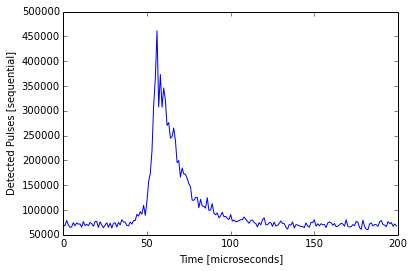

In [6]:
"""
Create Profiles of all GPs
"""

GPdynspec = np.zeros((len(bT), 1600))
GPstack = np.zeros((1600,49))
pad = np.zeros((100,1))
switch = 0

for i in range(len(bT)):
    if bT[i] > Time('2014-06-15T06:30:00'):
        if switch == 0:
            print(bT[i], i)
            switch = 1
    if bT[i] > Time('2014-06-16T06:30:00'):
        if switch == 1:
            print(bT[i], i)
            switch = 2   
    
    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (bT[i].isot))[:,:]
    p1 = np.concatenate((p1,pad), axis=-1)
    p1 = rechannelize(p1, 48)
    p1prof = abs(p1).sum(-1)
    p1 = np.roll(p1, 256-np.argmax(p1prof), axis=0)
    
    p2 = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (bT[i].isot))[:,:]
    p2 = np.concatenate((p2,pad), axis=-1)
    p2 = rechannelize(p2, 48)
    p2prof = abs(p2).sum(-1)
    p2 = np.roll(p2, 256-np.argmax(p2prof), axis=0)
    
    GPdynspec[i] = (abs(p1)**2.0).sum(1)
    GPstack += abs(p1)**2.0 + abs(p2)**2.0
        
    #except:
    #    print('file %s not found' % (bT[i].isot))

%matplotlib inline
#plt.imshow(GPstack.T, aspect='auto', interpolation='nearest')
plt.plot(GPstack[200:400].sum(1))
#plt.plot(GPdynspec.T + np.linspace(0,5e7,GPdynspec.shape[0])[np.newaxis,:])
plt.ylabel('Detected Pulses [sequential]')
plt.xlabel('Time [microseconds]')

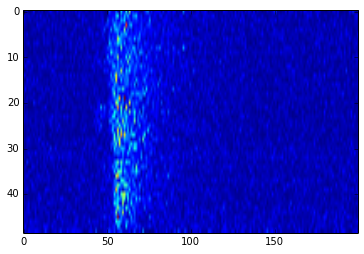

In [9]:
plt.imshow((GPstack[200:400] / GPstack[200:400].mean(0) - 1).T, aspect='auto')

np.save('b1957_pulsestack.npy', (GPstack[200:400] / GPstack[200:400].mean(0) - 1))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
/usr/lib/pymodules/python2.7/matplotlib/lines.py:503: RuntimeWarning: invalid value encountered in subtract
  return np.alltrue(x[1:] - x[0:-1] >= 0)
/usr/lib/pymodules/python2.7/matplotlib/lines.py:503: RuntimeWarning: invalid value encountered in greater_equal
  return np.alltrue(x[1:] - x[0:-1] >= 0)


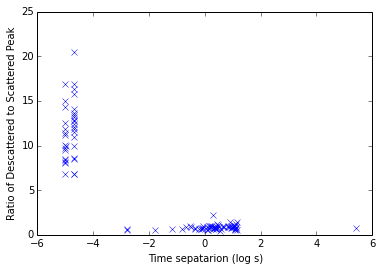

In [29]:
"""
Look for short Time Delay pulses
"""

T1 = bT.isot[bsort]
T2 = np.roll(bT.isot,1)[bsort]
#T2 = np.roll(T1[bsort], len(T1)//3)

npulses = 106
buff = 0
td = []
pratio = np.zeros(npulses)

for i in range(buff,npulses+buff):
    try:
        p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T1[i]))[:,256:513]
        p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))[:,256:513]
    except: 
        print("file %s does not exist" % (T1[i]))
    
    p1prof = (abs(rechannelize(p1,32))**2.0).sum(-1)
    p2prof = (abs(rechannelize(p2,32))**2.0).sum(-1)

    p1temp = np.roll(rechannelize(p1,32), 514-np.argmax(p1prof), axis=0)
    p2temp = np.roll(rechannelize(p2,32), 514-np.argmax(p2prof), axis=0)

    bg = p1prof[:250].mean(axis=0)
    
    p12corr = correlate(p2temp, p1temp, 32, 512)
    p12pcorr = correlate_power(p2temp, p1temp, 32, 512)

    pd = max( (abs(p12pcorr)**2.0).sum(1) - bg )
    ps = max(p2prof - bg)
    pratio[i-buff] = (pd / ps)
    td.append(abs(Time(T1[i]).unix - Time(T2[i]).unix))
    
#    if pratio[i] > 1.8:
#        print Time(T1[i]).isot
 
plt.plot(np.log10(td), pratio, 'bx')
#plt.plot(pratio, 'bx')
plt.xlabel('Time sepatarion (log s)')
plt.ylabel('Ratio of Descattered to Scattered Peak')

In [36]:
%matplotlib qt

plt.plot((abs(p12pcorr)**2.0).sum(1))
plt.plot(np.roll(p1prof,514-np.argmax(p1prof)))
plt.plot(np.roll(p2prof,514-np.argmax(p2prof)))   

In [30]:
p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))[:,511:]
Tcal = Time('2014-06-13T07:00:02.13597')

pb_dT = abs(bT.unix - Tcal.unix)
T2 = bT[pb_dT < 3600]

npulses = len(T2)
buff = 0
td = []
pratio = np.zeros(npulses)

for i in range(buff,npulses+buff):
    try:
        p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))[:,511:]
    except: 
        print("file %s does not exist" % (T2[i]))
    
    p1prof = (abs(rechannelize(p1,32))**2.0).sum(-1)
    p2prof = (abs(rechannelize(p2,32))**2.0).sum(-1)

    p1temp = np.roll(rechannelize(p1,32), 514-np.argmax(p1prof), axis=0)
    p2temp = np.roll(rechannelize(p2,32), 514-np.argmax(p2prof), axis=0)

    bg = p1prof[:250].mean(axis=0)
    
    p12corr = correlate(p2temp, p1temp, 32, 512)
    p12pcorr = correlate_power(p2temp, p1temp, 32, 512)

    pd = max( (abs(p12pcorr)**2.0).sum(1) - bg )
    ps = max(p2prof - bg)
    pratio[i-buff] = (pd / ps)
    td.append(abs(Tcal.unix - Time(T2[i]).unix))
    
    
%matplotlib qt
 
plt.plot(np.log10(td), pratio, 'bx')
plt.xlim(0,3.5)
#plt.plot(pratio, 'bx')
plt.xlabel('Time sepatarion (log s)')
plt.ylabel('Ratio of Descattered to Scattered Peak')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in log10


In [138]:
pb1 = 1.*np.array(pratio)
tb5 = 1.*np.array(td)

pball = np.concatenate((pb1,pb2,pb3,pb4))
tdall = np.concatenate((tb1,tb2,tb3,tb4))

%matplotlib qt
plt.plot(np.log10(tdall), pball, 'bx')

plt.xlabel('Time sepatarion (log s)')
plt.ylabel('Ratio of Descattered to Scattered Peak')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [140]:
"""
Look at all pulse pairs of a single very bright pulse

Compare between low and high lag correlation
"""

Tcal = Tphase[0]

buff = 0
wiener = 1
cchan = 32
fchan = 512

%matplotlib qt

for k in range(3):
    for j in range(len(Tphase)):

        td = []
        Tcal = Tphase[j]

        pb_dT = abs(bT.unix - Tcal.unix)
        T2 = bT[pb_dT < 3000]
        npulses = len(T2)
        pratio = np.zeros(npulses)
        pratio2 = np.zeros(npulses)

        p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (Tcal.isot))[:,:257]
        p1 = np.roll(p1, k*256, axis=1)[:,:257]

        for i in range(buff,npulses+buff):
            try:
                p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))[:,:257]
                p2 = np.roll(p2, k*256, axis=1)[:,:257]
            except: 
                print("file %s does not exist" % (T2[i]))

            p1prof = (abs(rechannelize(p1,32))**2.0).sum(-1)
            p2prof = (abs(rechannelize(p2,32))**2.0).sum(-1)

            p1temp = np.roll(rechannelize(p1,32), 514-np.argmax(p1prof), axis=0)
            p2temp = np.roll(rechannelize(p2,32), 514-np.argmax(p2prof), axis=0)

            bg = p2prof[100:300].mean(axis=0)

            if wiener:
                p12pcorr = wfilter(p1temp, p2temp, cchan, fchan)
                corrnorm = bg / (abs(p12pcorr[100:300])**2.0).sum(-1).mean(axis=0)
            else:
                p12pcorr1 = correlate_power(p2temp, p1temp, cchan, fchan)
                corrnorm = 1.

            pd = max( (abs(p12pcorr)**2.0).sum(1)*corrnorm - bg )
            ps = max(p2prof - bg)

            pd2 = max( (abs(p12pcorr)**2.0).sum(1)[520:528] - bg )
            ps2 = max( (abs(p2temp)**2.0).sum(1)[520:528] - bg )
            
            pratio[i-buff] = (pd / ps)
            pratio2[i-buff] = (pd2 / ps2)

            td.append(abs(Tcal.unix - Time(T2[i]).unix))            
                
        if j==0:
            pr1 = 1*pratio
            pr2 = 1*pratio2
            td1 = 1.*np.array(td)
        else:
            pr1 = np.concatenate((pr1,pratio))
            pr2 = np.concatenate((pr2,pratio2))
            td1 = np.concatenate((td1,np.array(td)))


        plt.plot(np.log10(td), pratio, 'bx')
        #plt.plot(np.log10(td), pratio2, 'rx')

    #plt.plot(np.log10(np.sort(td)), prun[np.argsort(td)] / 3, 'k--', label='mean')
    #plt.xlim(-,3.5)
    #plt.plot(pratio, 'bx')
    plt.xlabel('Time sepatarion (log s)')
    plt.ylabel('Ratio of Descattered to Scattered Peak')
    plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: RuntimeWarning: divide by zero encountered in log10


In [128]:
%matplotlib qt
from scipy.stats import binned_statistic

abins = np.logspace(0,4,13)

print binned_statistic(td1, pr1, statistic='mean', bins = abins)

b1 = binned_statistic(td1, pr1, statistic='mean', bins = abins)[0]
b2 = binned_statistic(td1, pr2, statistic='mean', bins = abins)[0]
print b1[len(b1)-4:]
plotbin = abins[1:] - abins[:-1]

#plt.plot(np.log10(plotbin), b1/b1[-4:-1].mean(), 'bx-', label='peak')
#plt.plot(np.log10(plotbin), b2/b2[-4:-1].mean(), 'rx-', label='tail')
#plt.plot(np.log10(plotbin), b3/b3[-4:-1].mean(), 'k+-', label='full')

plt.plot(np.log10(plotbin), b1, 'bx-', label='Wfilter')
#plt.plot(np.log10(plotbin), b2, 'rx-', label='FFT')
#plt.plot(np.log10(plotbin), b3/b3[-4:-1].mean(), 'k+-', label='full')

plt.xlabel('log(dt[s])')
plt.ylabel('Ratio of Descattered to Scattered Peak')
#plt.legend()

(array([ 3.4843974 ,         nan,         nan,  2.16911446,  1.42111191,
        1.07059366,  0.831737  ,  0.88962975,  0.84986198,  0.88610169,
        0.85897207,         nan]), array([  1.00000000e+00,   2.15443469e+00,   4.64158883e+00,
         1.00000000e+01,   2.15443469e+01,   4.64158883e+01,
         1.00000000e+02,   2.15443469e+02,   4.64158883e+02,
         1.00000000e+03,   2.15443469e+03,   4.64158883e+03,
         1.00000000e+04]), array([10,  9,  9,  9,  8,  8,  6,  6,  6,  0,  0,  0,  1,  1,  4,  5,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  7,  7,  7,  0,  0,  6,  7,
        7,  7,  7,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 1

In [ ]:
"""
Fold giant pulses on each other, as well as de-convolved folded spectrum 
"""



In [8]:
%matplotlib qt
plt.plot(abs(p2temp).sum(1))
plt.plot(abs(p12pcorr).sum(1))
plt.xlabel(log(dt[s]))
plt.ylabel('Ratio of Descattered to Scattered Peak')

ERROR: NameError: name 'p2temp' is not defined [IPython.core.interactiveshell]


NameError: name 'p2temp' is not defined

In [217]:
"""
Work with our best pulse pair

Compare straight deconvolution with Wiener Filter
"""
%matplotlib qt

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:21.91125'))[:,:257]
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:23.83364'))[:,:257]

p1prof = (abs(rechannelize(p1,32))**2.0).sum(-1)
p2prof = (abs(rechannelize(p2,32))**2.0).sum(-1)

p1temp = np.roll(rechannelize(p1,32), 514-np.argmax(p1prof), axis=0)
p2temp = np.roll(rechannelize(p2,32), 514-np.argmax(p2prof), axis=0)

### Wiener filter stuff

p1fine = rechannelize(p1temp, 512)
p2fine = rechannelize(p2temp, 512)

SN = (abs(p1fine[32])- abs(p1fine[:20]).mean(axis=0)) / abs(p1fine)[:20].std(axis=0)
SN[SN < 0.01] = 0.01
H = p1fine / abs(p1fine)
G = (1 / H) * ( abs(H)**2.0 / (abs(H)**2.0 + (1/SN[np.newaxis,:])) )
Y = p2fine

x = rechannelize(G * Y, 32)

###

p12pcorr = correlate_power(p2temp, p1temp, 32, 512)

sn_psP = (abs(p2temp)**2.0).sum(-1)
sn_psP1 = (abs(p1temp)**2.0).sum(-1)
sn_dsP = (abs(p12pcorr)**2.0).sum(-1)
sn_wsP = (abs(x)**2.0).sum(-1)
sn_ps = (sn_psP - sn_psP[:400].mean(axis=0)) / sn_psP[:400].std(axis=0)
sn_ps1 = (sn_psP1 - sn_psP1[:400].mean(axis=0)) / sn_psP1[:400].std(axis=0)
sn_ds = (sn_dsP - sn_dsP[:400].mean(axis=0)) / sn_dsP[:400].std(axis=0)
sn_ws = (sn_wsP - sn_wsP[:400].mean(axis=0)) / sn_wsP[:400].std(axis=0)


plt.plot(sn_ps, label='original pulse')
plt.plot(sn_ps1, label='original pulse')
plt.plot(sn_ds, label='FFT deconvolution')
#plt.plot(sn_ws, label='Wiener deconvolution')

print(sn_ds[500:540].sum(0), sn_ps[500:540].sum(0), sn_ps1[500:540].sum(0))

plt.plot()

plt.xlim(450,620)
plt.legend()

(45.034462912508303, -10.87758041200202, -10.323661982905984)


In [238]:
"""
Work with our best pulse pair

Compare straight deconvolution with Wiener Filter
"""
%matplotlib qt

cchan = 4

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:21.91125'))[:,:257]
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:23.83364'))[:,:257]

p1prof = (abs(rechannelize(p1,cchan))**2.0).sum(-1)
p2prof = (abs(rechannelize(p2,cchan))**2.0).sum(-1)

p1temp = np.roll(rechannelize(p1,cchan), 1024+40-np.argmax(p1prof), axis=0)
p2temp = np.roll(rechannelize(p2,cchan), 1024+40-np.argmax(p2prof), axis=0)

p12pcorr = correlate_power(p2temp, p1temp, cchan, 512)

sn_psP = (abs(p2temp)**2.0).sum(-1)
sn_psP1 = (abs(p1temp)**2.0).sum(-1)
sn_dsP = (abs(p12pcorr)**2.0).sum(-1)
sn_wsP = (abs(x)**2.0).sum(-1)
sn_ps = (sn_psP - sn_psP[:400].mean(axis=0)) / sn_psP[:400].std(axis=0)
sn_ps1 = (sn_psP1 - sn_psP1[:400].mean(axis=0)) / sn_psP1[:400].std(axis=0)
sn_ds = (sn_dsP - sn_dsP[:400].mean(axis=0)) / sn_dsP[:400].std(axis=0)
sn_ws = (sn_wsP - sn_wsP[:400].mean(axis=0)) / sn_wsP[:400].std(axis=0)

x2 = dechannelize(p12pcorr)

plt.plot(sn_ps, label='pulse1')
plt.plot(sn_ps1, label='pulse2')
plt.plot(sn_ds, label='FFT deconvolution')
#plt.plot(sn_ws, label='Wiener deconvolution')

plt.plot()

#plt.xlim(450,620)
plt.legend()
plt.xlabel('')

In [143]:
%matplotlib qt
plt.plot(tdyncorr, ccarray / 40, label='dynspec corr')
plt.plot(tdyncorr, (dyncorr-dyncorr.mean()/1.4) / dyncorr.std(), label='GP dynspec corr' )
plt.plot(plotbin, b1, 'rx-', label='GP descattering' )

plt.xscale('log')
plt.xlabel('time')
plt.ylabel('corr strength')
plt.legend()

In [133]:
print(b1.shape)

(12,)


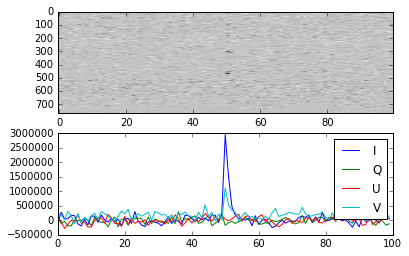

In [21]:
%matplotlib inline
t_gp = bT[0]
GPR = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
try: 
    GPL = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))
except:
    GPL = np.zeros_like(GPR)
    
plt.subplot(211)

I, Q, U, V = Stokes(GPR, GPL)

plt.imshow(V.T, aspect='auto', cmap=cm.Greys)

plt.subplot(212)
plt.plot((I-I[:40].mean(0)).sum(1), label='I')
plt.plot(Q.sum(1), label='Q')
plt.plot(U.sum(1), label='U')
plt.plot(V.sum(1), label='V')
plt.legend()


In [59]:
Ia = []
Qa = []
Ua = []
Va = []

for t_gp in bT:
    GPR = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
    try: 
        GPL = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))
    except:
        GPL = np.zeros_like(GPR)
    
    #plt.subplot(211)
    #plt.imshow(abs(GPR).T, aspect='auto', cmap=cm.Greys)

    I, Q, U, V = Stokes(GPR, GPL)
    Imax = np.argmax(abs(I.sum(-1)))
    #Qmax = np.argmax(abs(Q.sum(-1))
    #Umax = np.argmax(abs(U.sum(-1))
    #Vmax = np.argmax(abs(V.sum(-1))

    Ia.append((I[Imax]-I[20:40].mean(0)).sum(-1))
    Qa.append((Q[Imax]-Q[20:40].mean(0)).sum(-1))
    Ua.append((U[Imax]-U[20:40].mean(0)).sum(-1))
    Va.append((V[Imax]-V[20:40].mean(0)).sum(-1))

Ia = np.array(Ia)
Qa = np.array(Qa) / Ia
Ua = np.array(Ua) / Ia
La = np.sqrt(Qa**2.0 + Ua**2.0)
Va = np.array(Va) / Ia

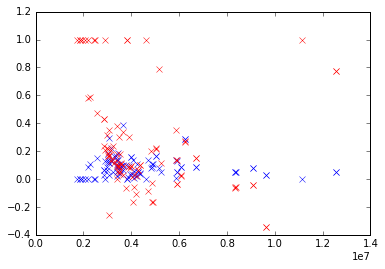

In [60]:
%matplotlib inline
plt.plot(Ia,La, 'bx', label='L')
plt.plot(Ia,Va, 'rx', label='V')
#plt.legend()


In [58]:
Ia = []
Qa = []
Ua = []
Va = []

for t_gp in bT:
    GPL = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))
    try: 
        GPR = np.load('/media/ramain/My Passport/Algo2016/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
    except:
        GPR = np.zeros_like(GPL)
    
    #plt.subplot(211)
    #plt.imshow(abs(GPR).T, aspect='auto', cmap=cm.Greys)

    I, Q, U, V = Stokes(GPR, GPL)
    Imax = np.argmax(abs(I.sum(-1)))
    #Qmax = np.argmax(abs(Q.sum(-1))
    #Umax = np.argmax(abs(U.sum(-1))
    #Vmax = np.argmax(abs(V.sum(-1))

    Ia.append((I[Imax]-I[20:40].mean(0)).sum(-1))
    Qa.append((Q[Imax]-Q[20:40].mean(0)).sum(-1))
    Ua.append((U[Imax]-U[20:40].mean(0)).sum(-1))
    Va.append((V[Imax]-V[20:40].mean(0)).sum(-1))
    
Ia = np.array(Ia)
Qa = np.array(Qa) / Ia
Ua = np.array(Ua) / Ia
Va = np.array(Va) / Ia

IOError: [Errno 2] No such file or directory: '/media/ramain/My Passport/Algo2016/b1957-GPs/LGPs/GP2014-06-13T06:09:02.12064.npy'

In [78]:
n = len(bT)
dT = np.zeros(n**2)
for i in range(n):
    for j in range(n):
        dT[n*i+j] = bT[j].unix - bT[i].unix
        
        

In [289]:
"""
Look at Polarization Profile of Brightest Pulses
"""

GP_Tlist = Time(['2014-06-13T06:01:21.91125', '2014-06-13T06:19:34.04710',
 '2014-06-13T06:49:56.52016', '2014-06-13T07:00:02.13597',
 '2014-06-14T07:05:58.73615', '2014-06-13T07:45:04.81882',
 '2014-06-13T07:09:27.16265', '2014-06-16T07:09:37.37528'], precision=5)

#['2014-06-13T07:09:27.16265' 
# '2014-06-14T07:05:58.73615']


#t_gp = Time('2014-06-13T06:01:21.91125', precision=5)
t_gp = Time('2014-06-13T07:00:02.13597', precision=5)
t_gp = Time('2014-06-13T06:49:56.52016', precision=5)

pad = np.zeros((100,1))

for t_gp in GP_Tlist:

    GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
    GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

    GPR = np.concatenate((GPR,pad), axis=-1)
    GPL = np.concatenate((GPL,pad), axis=-1)

    GPR = rechannelize(GPR, 48)[750:900]
    GPL = rechannelize(GPL, 48)[750:900]

    I, Q, U, V = Stokes(GPR, GPL)

    L = Q + 1j*U

    plt.subplot(211)
    plt.plot(I.sum(1) - I.sum(1)[:40].mean(0), 'k', label='I')
    plt.plot(abs(L).sum(1) - abs(L).sum(1)[:40].mean(0), 'r', label='|L|')
    plt.plot(V.sum(1) - V.sum(1)[:40].mean(0), 'b', label='V')
    plt.legend()
    
    plt.subplot(212)
    plt.plot(np.angle(Q.sum(1) + 1j*U.sum(1)), 'kx')
    
    plt.xlabel('Time [microseconds]')
    plt.ylabel('Intensity')
    
    plt.savefig('b1957_GP%s.pdf' % (t_gp.isot))
    plt.clf()

In [51]:
t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
t_p = Time('2014-06-13T06:01:23.83364', precision=5)

pad = np.zeros((100,1))


p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_ref.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p.isot))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)

p1temp = np.roll(p1, 514-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2, 514-np.argmax(abs(p2temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
p2prof = rechannelize(p2temp, 4*3)

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

corr = dechannelize(corr)

%matplotlib qt
plt.plot(corr,'k' , label='de-scattered peak')
#plt.plot(t_axis, (abs(p2prof)**2.0).sum(-1), 'r', label='measured emission')

#plt.xlim(80, 180)
plt.ylabel('Intensity [arbitrary units]')
plt.xlabel('Time [microseconds]')
plt.legend()
#plt.savefig('descatter-bestpair.pdf')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
